# Cancer detection in breast ultrasound images dataset

## Import Modules

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
import pandas as pd
import seaborn as sns
import cv2
from PIL import Image
import os
from glob import glob
import datetime

from pathlib import Path

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, MaxPooling2D, concatenate
from tensorflow.keras.layers import SpatialDropout2D, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, normalize
from tensorflow.keras.metrics import IoU, MeanIoU
from tensorflow.keras import backend as K
import segmentation_models as sm

from helper_functions import make_confusion_matrix, plot_loss_curves, calculate_results
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split


import scipy.ndimage as ndi

from skimage import color
from skimage.filters import try_all_threshold, sobel
from skimage import exposure
from skimage.transform import resize
from skimage import morphology
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from skimage.feature import canny


## Load Data

In [2]:
# root folder
root_path = "Dataset_BUSI_with_GT/"

# classes in the analyzed data
classes = os.listdir(root_path)
classes

['benign', 'malignant', 'normal']

In [3]:
# Amount of images
image_paths_bening = glob(root_path + f"{classes[0]}"+"/*).png")
image_paths_malignant = glob(root_path + f"{classes[1]}"+"/*).png")
image_paths_normal = glob(root_path + f"{classes[2]}"+"/*).png")
print(f"Total number of images is:\nNORMAL - {len(image_paths_normal)} \
                                  \nMALIGNANT - {len(image_paths_malignant)} \
                                  \nBENING - {len(image_paths_bening)}")

Total number of images is:
NORMAL - 133                                   
MALIGNANT - 210                                   
BENING - 437


### We can see that we have a class imbalance problem in data

In [4]:
def loadImage(image_path, shape):
    image = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_path))
    image = cv2.resize(image, (shape, shape))
    image = tf.cast(image, tf.float32)
    image /= 255.
    return image

In [5]:
def loadImageV2(image_path, size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (shape, shape))
    image = Image.fromarray(image)
    image = image.resize((size, size))
    return image

In [6]:
def num(filename):
    val = 0
    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break
    return val

In [7]:
def createDataset(images, masks, batch_size):
    data = tf.data.Dataset.from_tensor_slices((images, masks))
    data = data.shuffle(1000).batch(batch_size, drop_remainder=True)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

In [30]:
def loadData(path = None, size = 256, files=False, batch_size=16, split=0.15):
    '''
    Function to load data from specific folder and in specific shape
    '''
    classes = os.listdir(os.path.join(path,""))
    benign_path = []
    malignant_path = []
    normal_path = []
    
    for single_class in classes:
        images_and_mask = glob(os.path.join(path, "", single_class, "*"))
        if single_class == "benign":
            benign_path += images_and_mask
        elif single_class == "malignant":
            malignant_path += images_and_mask
        else:
            normal_path += images_and_mask
    
    benign_image, benign_mask = np.zeros((437, size, size, 3)), \
                                np.zeros((437, size, size, 1))
    
    
    malignant_image, malignant_mask = np.zeros((210, size, size, 3)), \
                                      np.zeros((210, size, size, 1))
    
    
    normal_image, normal_mask = np.zeros((133, size, size, 3)), \
                                np.zeros((133, size, size, 1))
    
    for image in benign_path:
        img = loadImageV2(image, size)
        if "mask" in image:
            benign_mask[num(image)-1] += img_to_array(img)
        else:
            benign_image[num(image)-1] += img_to_array(img)
            
    for image in malignant_path:
        img = loadImageV2(image, size)
        if "mask" in image:
            malignant_mask[num(image)-1] += img_to_array(img)
        else:
            malignant_image[num(image)-1] += img_to_array(img)
    
    for image in normal_path:
        img = loadImageV2(image, size)
        if "mask" in image:
            normal_mask[num(image)-1] += img_to_array(img)
        else:
            normal_image[num(image)-1] += img_to_array(img)
    
    images = np.concatenate((benign_image, malignant_image, normal_image), axis=0).astype(np.float32)/255.
    masks = np.concatenate((benign_mask, malignant_mask, normal_mask), axis=0).astype(np.uint8)/255.
    
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=split)
    
    train_data = createDataset(X_train, y_train, batch_size)
    test_data = createDataset(X_val, y_val, batch_size)
    
    print("Used memory to store the float image dataset is: ", images.nbytes/(1024*1024))
    print("Used memory to store the float mask dataset is: ", masks.nbytes/(1024*1024))
    
    if files:
        return train_data, test_data, X_train, X_val, y_train, y_val
    
    return train_data, test_data

In [9]:
train_data, test_data = loadData(path="Dataset_BUSI_with_GT", files=False, batch_size=8, size=128)

In [23]:
def show_images(data, model=None, explain=False, n_images=4, SIZE=(30,15)):
    
    # Plot Configurations
    if model is not None:
        if explain:
            n_cols = 4
        else:
            n_cols = 4
    else:
        n_cols = 3
    
    # Iterate through data 
    for plot_no in range(1, n_images+1):
        for index, (images, masks) in enumerate(iter(data)):
            
            # Select Items 
            id = np.random.randint(len(images))
            image, mask = images[id], masks[id]
            
            if model is not None:
                
                if explain:
                    
                    # Make Prediction
                    pred_mask = model.predict(image[np.newaxis, ...]>0.5)[0]
                    
                    # Figure
                    plt.figure(figsize=SIZE)

                    # Original Image
                    plt.subplot(1, n_cols, 1)
                    plt.imshow(image, cmap='gray')
                    plt.axis('off')
                    plt.title("Original Image")

                    # Original Mask
                    plt.subplot(1, n_cols, 2)
                    plt.imshow(mask, cmap='gray')
                    plt.axis('off')
                    plt.title('Original Mask')

                    # Predicted Mask
                    plt.subplot(1, n_cols, 3)
                    plt.imshow(pred_mask, cmap='gray')
                    plt.axis('off')
                    plt.title("Predicted Mask")

                    # Mixed
                    plt.subplot(1, n_cols, 4)
                    plt.imshow(image, cmap='gray')
                    plt.imshow(pred_mask, alpha=0.4)
                    plt.axis('off')
                    plt.title("Overlaped Prediction")

                    # Show Image
                    plt.show()
                
            else:
                
                # Figure
                plt.figure(figsize=SIZE)
                
                # Original Image
                plt.subplot(1, n_cols, 1)
                plt.imshow(image, cmap='gray')
                plt.axis('off')
                plt.title("Original Image")
                
                # Original Mask
                plt.subplot(1, n_cols, 2)
                plt.imshow(mask, cmap='gray')
                plt.axis('off')
                plt.title('Original Mask')
                
                # Mixed
                plt.subplot(1, n_cols, 3)
                plt.imshow(image, cmap='gray')
                plt.imshow(mask, alpha=0.4, cmap='gray')
                plt.axis('off')
                plt.title("Overlaped Image")
                
                # Show Image
                plt.show()
            
            # Break Loop
            break

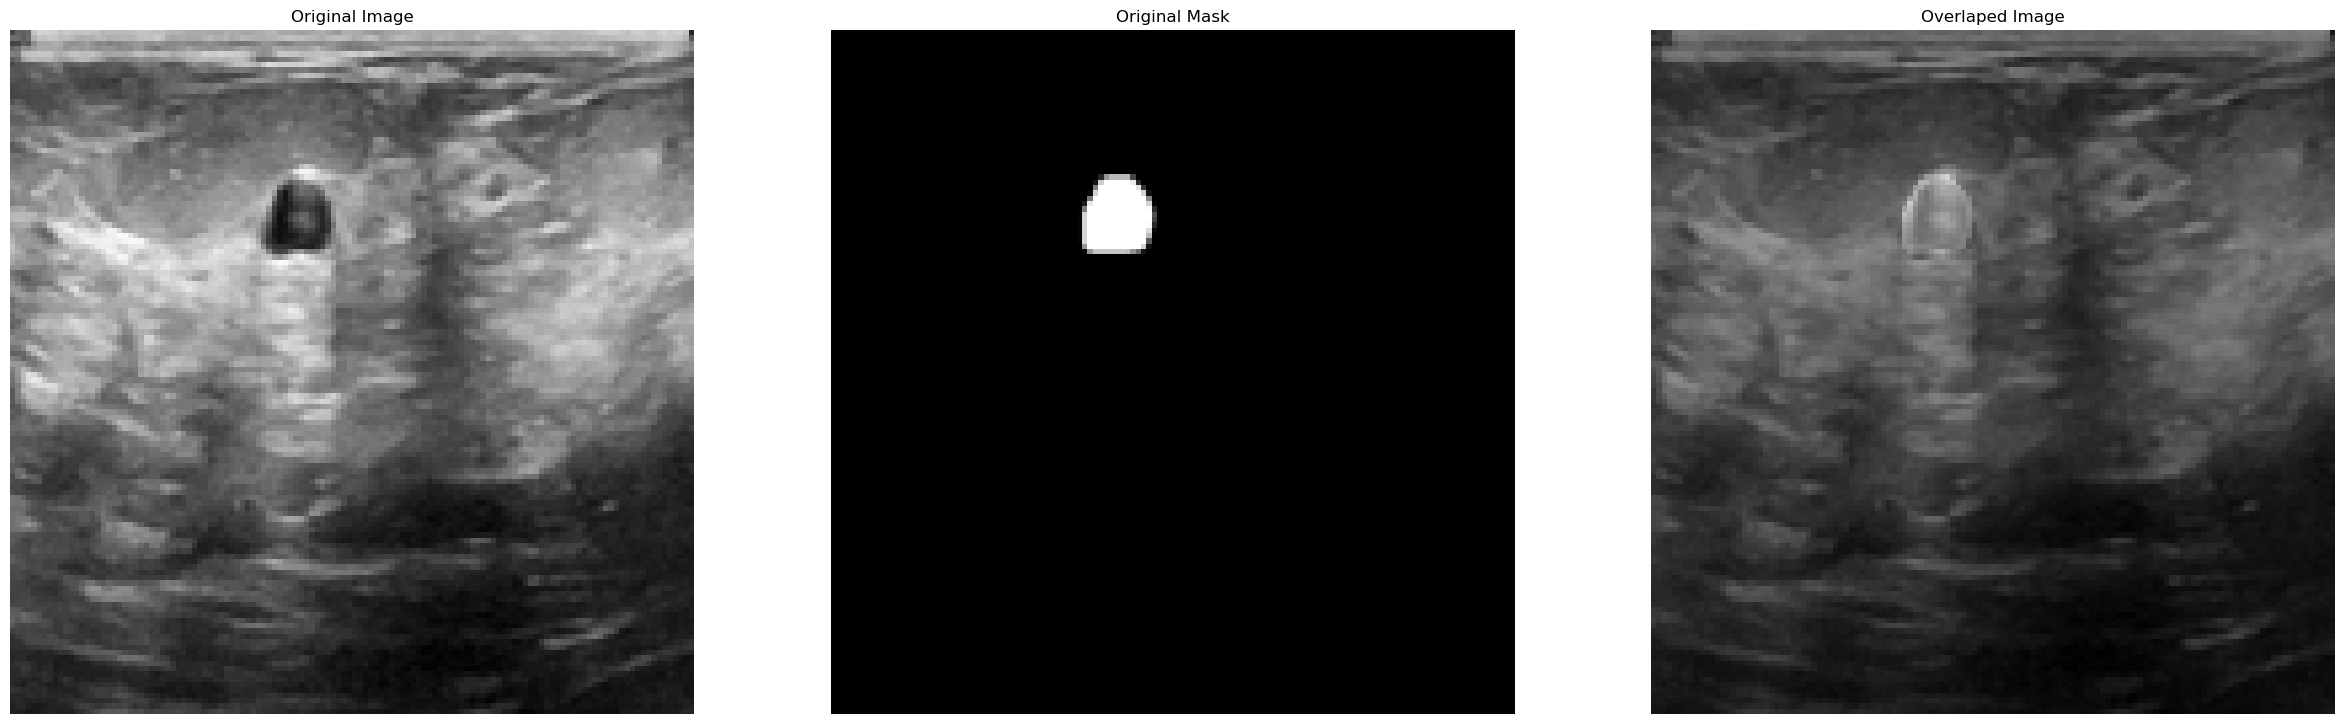

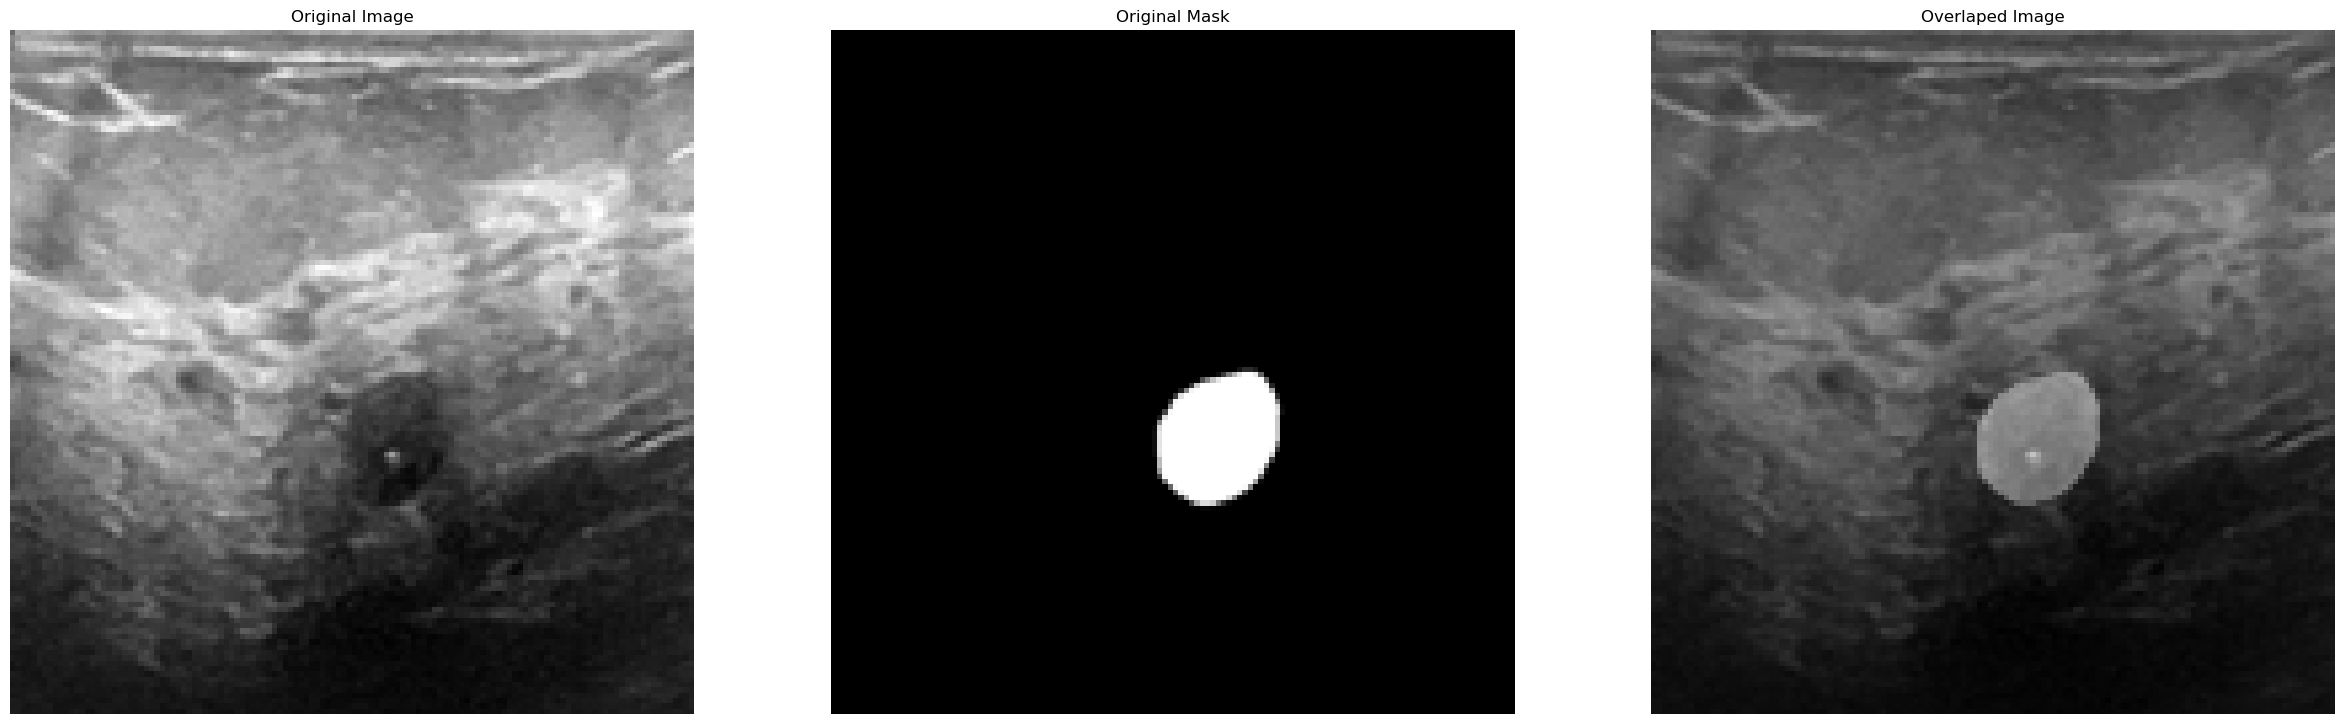

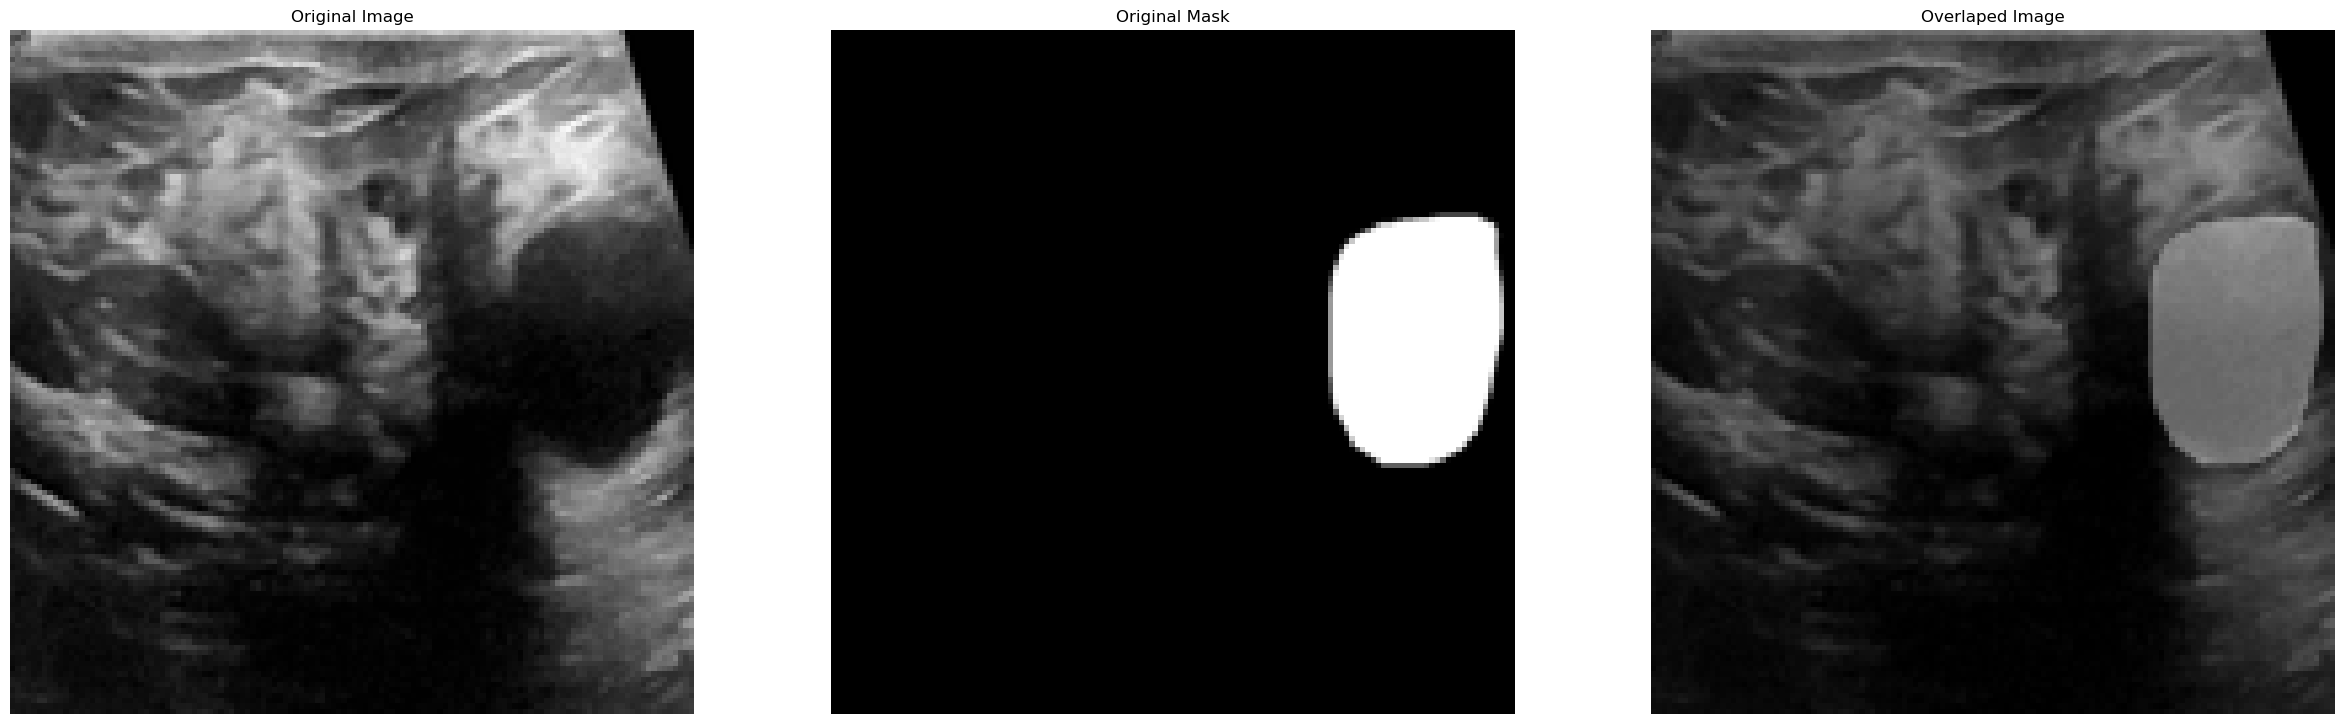

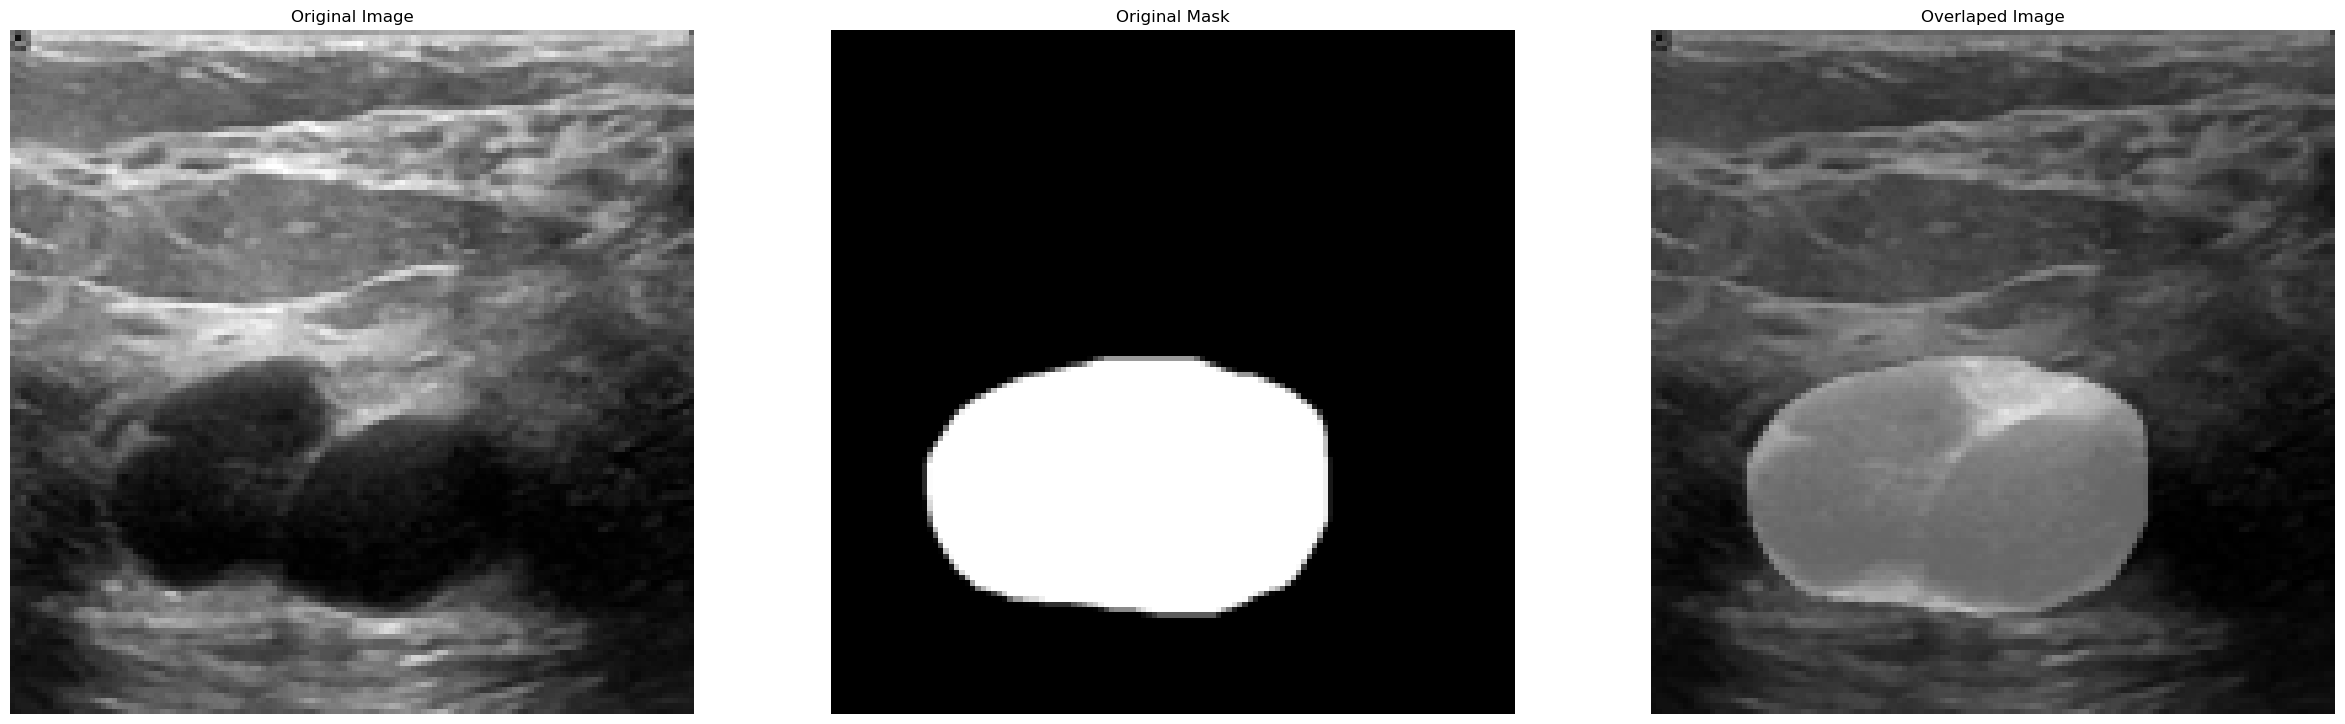

In [11]:
show_images(data=train_data)

In [12]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [13]:
def jaccard_loss_function(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

In [14]:
def dice_loss1(y_true, y_pred, smooth=1e-6):
#     y_pred = tf.convert_to_tensor(y_pred)
#     y_true = tf.cast(y_true, y_pred.dtype)
#     smooth = tf.cast(smooth, y_pred.dtype)
    
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    
    intersection = K.sum(y_true * y_pred) 
    dice_coef = (2 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    dice_loss = 1-dice_coef
    return dice_loss

In [15]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(input)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [16]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

In [17]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(input)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [18]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    b1 = conv_block(p4, 1024) # Bridge
     
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss=[dice_loss1], 
                  metrics=[sm.metrics.IOUScore(threshold=0.5)])
    model.summary()
    
    return model

In [19]:
model = simple_unet_model(128, 128, 3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_9 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 8, 8, 1024)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2097664    ['activation_9[0][0]']           
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 16, 16, 1024  0           ['conv2d_transpose[0][0]',       
                                )                                 'activation_7[0][0]']           
          

 batch_normalization_17 (BatchN  (None, 128, 128, 64  256        ['conv2d_17[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_17 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 1)  65          ['activation_17[0][0]']          
                                                                                                  
Total params: 31,055,297
Trainable params: 31,043,521
Non-trainable params: 11,776
__________________________________________________________________________________________________


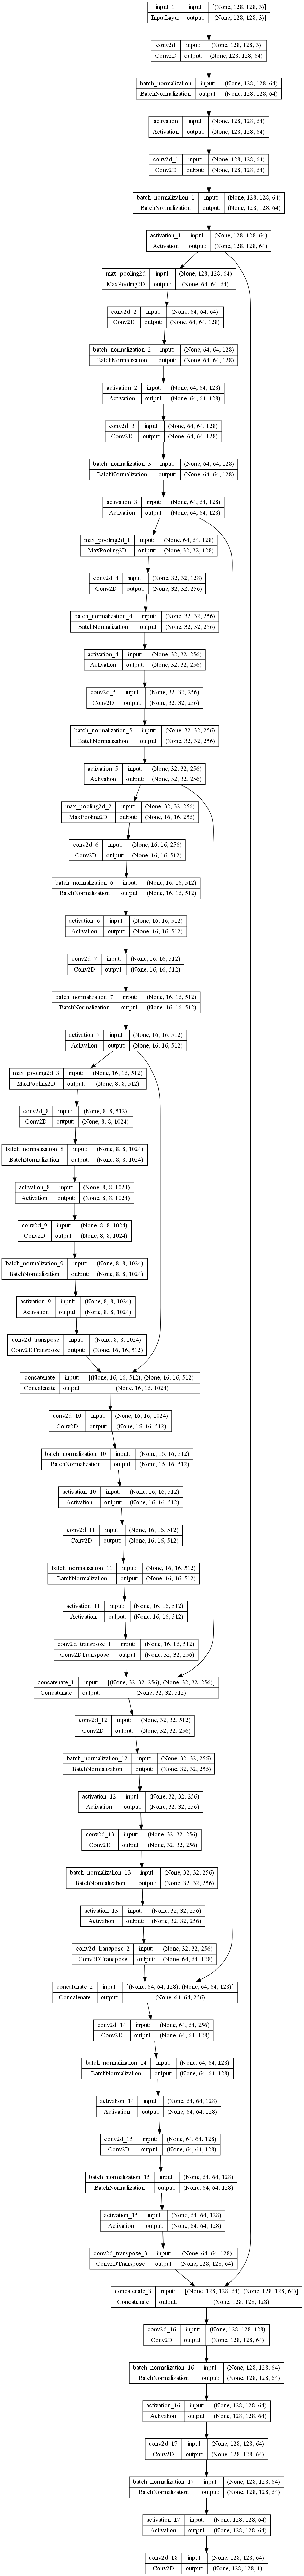

In [20]:
plot_model(model, show_shapes=True)

In [21]:
#Callback
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%5==0:
            show_images(test_data, model=self.model, explain=True, n_images=2, SIZE=(25,10))

def create_tensorboard_callback(dir_name, experiment_name):
    """
        Creates a TensorBoard callback instand to store log files.
        Stores log files with the filepath:
        "dir_name/experiment_name/current_datetime/"
    Args:
        dir_name: target directory to store TensorBoard log files
        experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

            
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-12)

# save weights for future use (e.g. reload parameters w/o training)
model_checkpoint = ModelCheckpoint(filepath="training_inzynierka/checkpoint",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# stop if our model doesn't improve
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               mode='auto',
                               restore_best_weights=True)

callbacks = [ShowProgress(), lr_reducer, model_checkpoint, early_stopping, 
             create_tensorboard_callback("training_inzynierka", "Base_Unet_dice_loss")]

Saving TensorBoard log files to: training_inzynierka/Base_Unet_dice_loss/20221215-003117


Epoch 1/500
82/82 [==============================] - ETA: 0s - loss: 0.6962 - iou_score: 0.2383
Epoch 1: val_loss improved from inf to 0.80318, saving model to training_inzynierka\checkpoint


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


82/82 [==============================] - 45s 396ms/step - loss: 0.6962 - iou_score: 0.2383 - val_loss: 0.8032 - val_iou_score: 0.1489 - lr: 1.0000e-04
Epoch 2/500
82/82 [==============================] - ETA: 0s - loss: 0.5373 - iou_score: 0.4075
Epoch 2: val_loss improved from 0.80318 to 0.75433, saving model to training_inzynierka\checkpoint


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


82/82 [==============================] - 32s 391ms/step - loss: 0.5373 - iou_score: 0.4075 - val_loss: 0.7543 - val_iou_score: 0.1693 - lr: 1.0000e-04
Epoch 3/500
82/82 [==============================] - ETA: 0s - loss: 0.4918 - iou_score: 0.4459
Epoch 3: val_loss did not improve from 0.75433
82/82 [==============================] - 18s 221ms/step - loss: 0.4918 - iou_score: 0.4459 - val_loss: 0.7772 - val_iou_score: 0.1347 - lr: 1.0000e-04
Epoch 4/500
82/82 [==============================] - ETA: 0s - loss: 0.4480 - iou_score: 0.4891
Epoch 4: val_loss did not improve from 0.75433
82/82 [==============================] - 18s 221ms/step - loss: 0.4480 - iou_score: 0.4891 - val_loss: 0.8994 - val_iou_score: 0.0484 - lr: 1.0000e-04
Epoch 5/500
1/1 [==============================] - 1s 846ms/steposs: 0.4210 - iou_score: 0.50


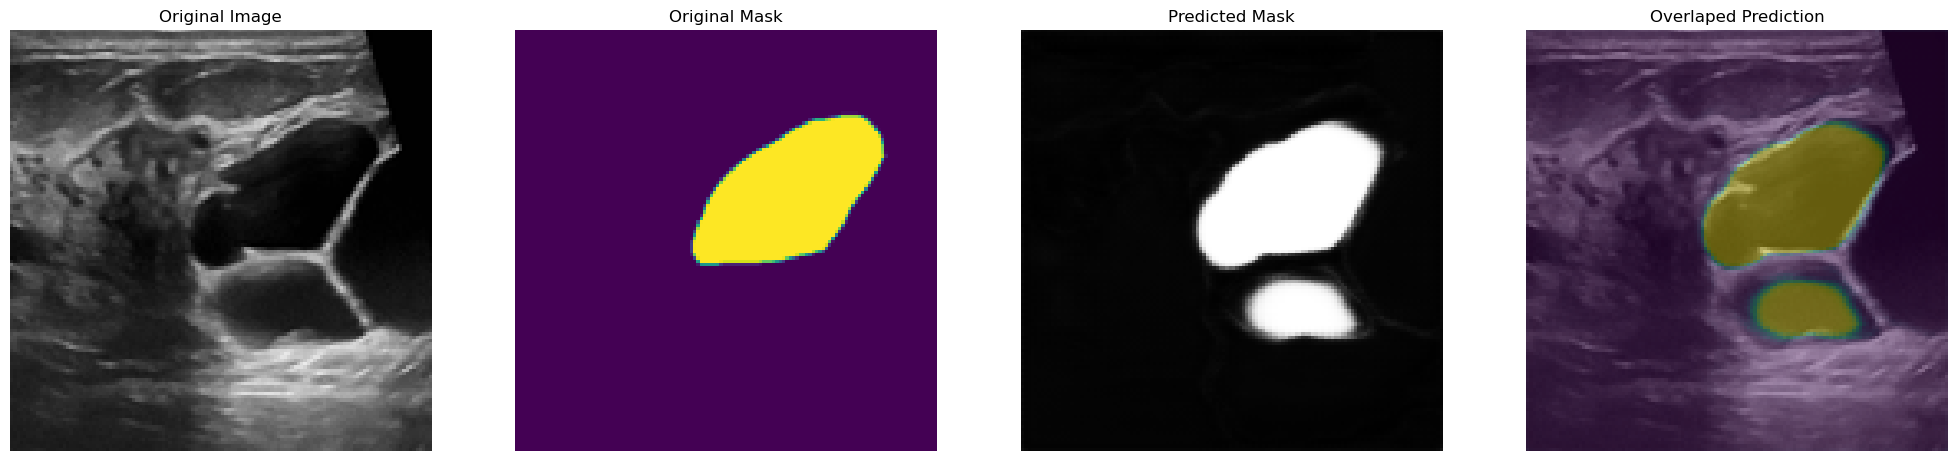

1/1 [==============================] - 0s 24ms/step


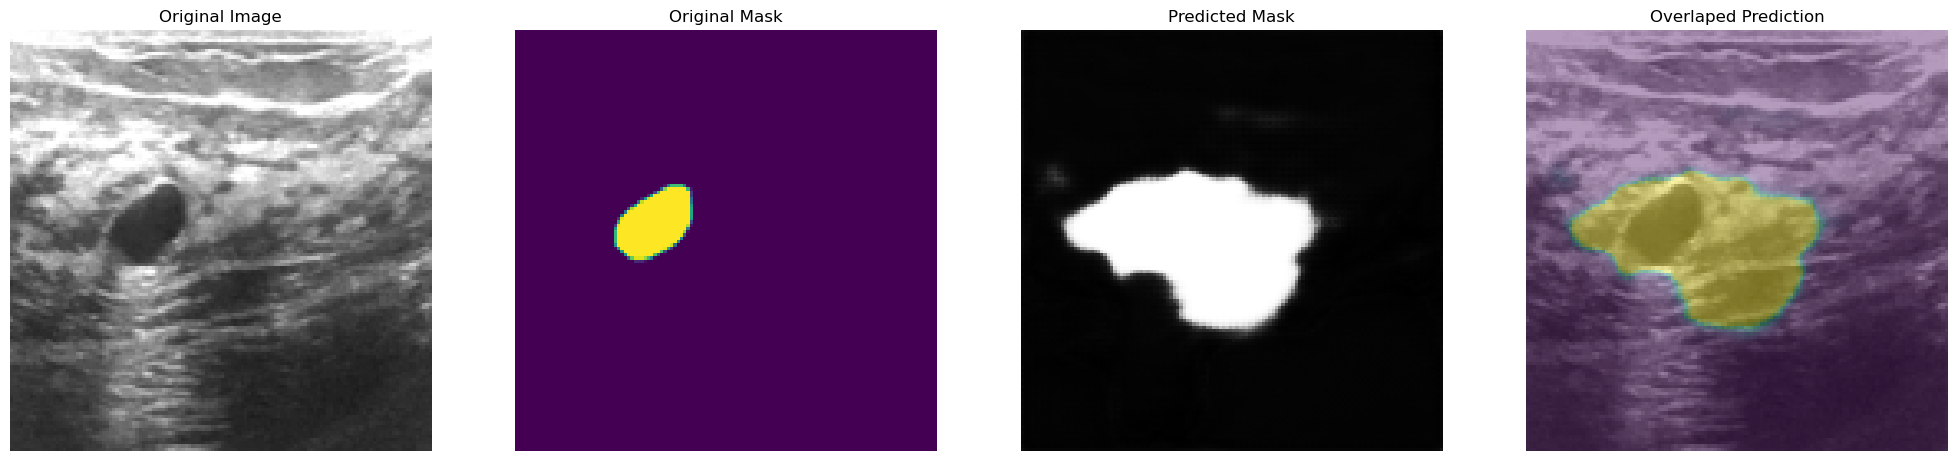


Epoch 5: val_loss improved from 0.75433 to 0.53045, saving model to training_inzynierka\checkpoint


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


82/82 [==============================] - 33s 406ms/step - loss: 0.4210 - iou_score: 0.5034 - val_loss: 0.5304 - val_iou_score: 0.3590 - lr: 1.0000e-04
Epoch 6/500
82/82 [==============================] - ETA: 0s - loss: 0.3981 - iou_score: 0.5165
Epoch 6: val_loss improved from 0.53045 to 0.45759, saving model to training_inzynierka\checkpoint


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


82/82 [==============================] - 32s 389ms/step - loss: 0.3981 - iou_score: 0.5165 - val_loss: 0.4576 - val_iou_score: 0.4566 - lr: 1.0000e-04
Epoch 7/500
82/82 [==============================] - ETA: 0s - loss: 0.3671 - iou_score: 0.5523
Epoch 7: val_loss did not improve from 0.45759
82/82 [==============================] - 18s 221ms/step - loss: 0.3671 - iou_score: 0.5523 - val_loss: 0.4586 - val_iou_score: 0.4172 - lr: 1.0000e-04
Epoch 8/500
82/82 [==============================] - ETA: 0s - loss: 0.3281 - iou_score: 0.5831
Epoch 8: val_loss improved from 0.45759 to 0.31304, saving model to training_inzynierka\checkpoint


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


82/82 [==============================] - 32s 391ms/step - loss: 0.3281 - iou_score: 0.5831 - val_loss: 0.3130 - val_iou_score: 0.6126 - lr: 1.0000e-04
Epoch 9/500
82/82 [==============================] - ETA: 0s - loss: 0.3472 - iou_score: 0.5518
Epoch 9: val_loss did not improve from 0.31304
82/82 [==============================] - 18s 221ms/step - loss: 0.3472 - iou_score: 0.5518 - val_loss: 0.4424 - val_iou_score: 0.4415 - lr: 1.0000e-04
Epoch 10/500
1/1 [==============================] - 0s 24ms/steploss: 0.3092 - iou_score: 0.59


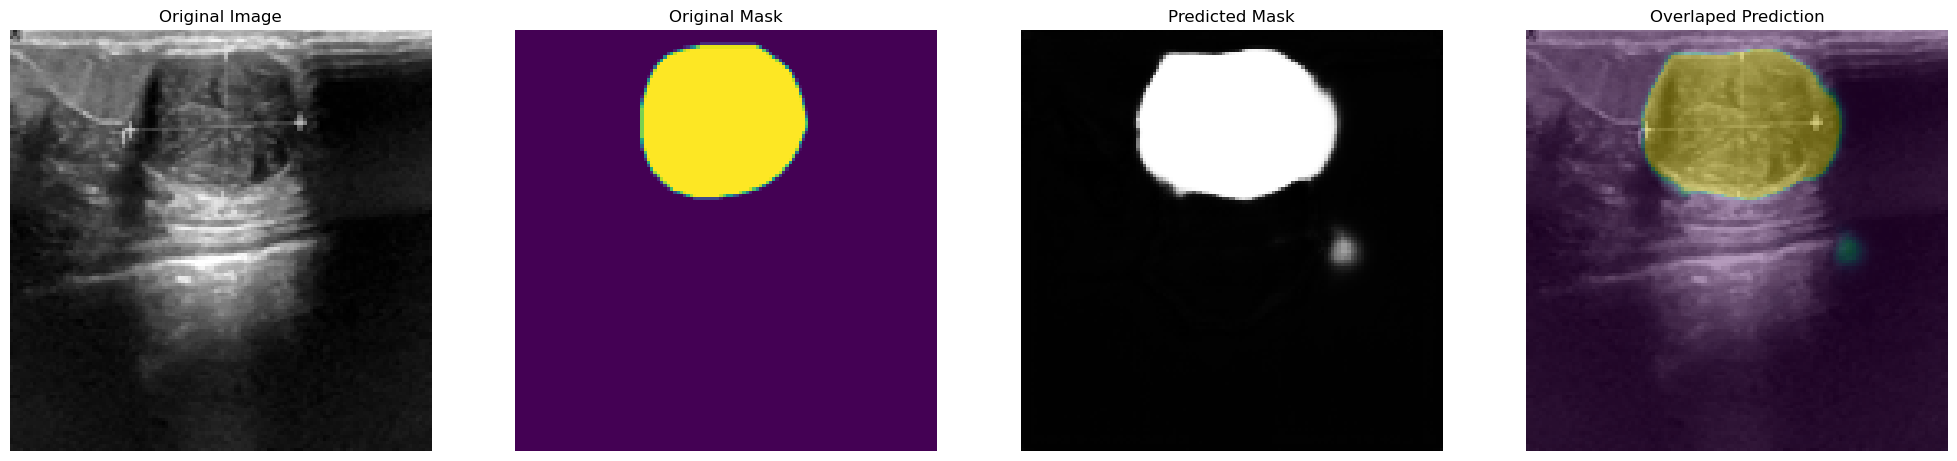

1/1 [==============================] - 0s 24ms/step


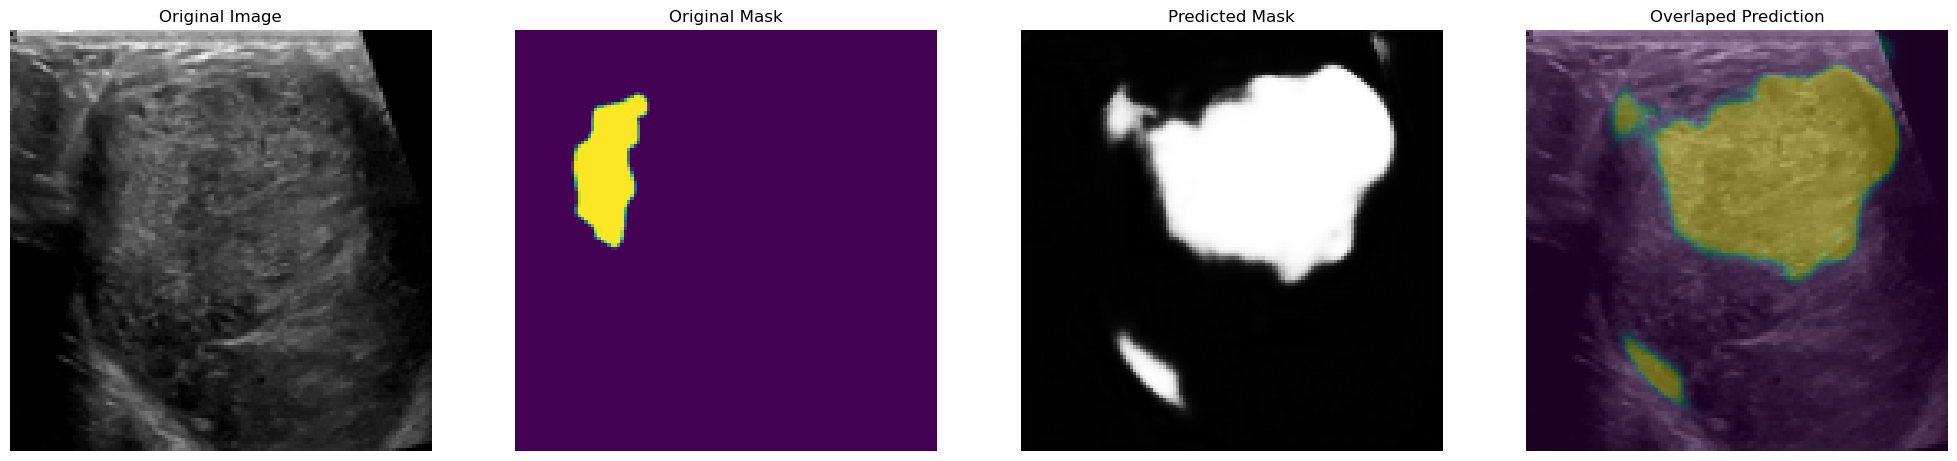


Epoch 10: val_loss did not improve from 0.31304
82/82 [==============================] - 19s 228ms/step - loss: 0.3092 - iou_score: 0.5913 - val_loss: 0.3709 - val_iou_score: 0.5415 - lr: 1.0000e-04
Epoch 11/500
82/82 [==============================] - ETA: 0s - loss: 0.2971 - iou_score: 0.6031
Epoch 11: val_loss did not improve from 0.31304
82/82 [==============================] - 18s 221ms/step - loss: 0.2971 - iou_score: 0.6031 - val_loss: 0.3135 - val_iou_score: 0.5934 - lr: 1.0000e-04
Epoch 12/500
82/82 [==============================] - ETA: 0s - loss: 0.2772 - iou_score: 0.6226
Epoch 12: val_loss did not improve from 0.31304
82/82 [==============================] - 18s 221ms/step - loss: 0.2772 - iou_score: 0.6226 - val_loss: 0.3881 - val_iou_score: 0.4721 - lr: 1.0000e-04
Epoch 13/500
82/82 [==============================] - ETA: 0s - loss: 0.2751 - iou_score: 0.6167
Epoch 13: val_loss did not improve from 0.31304
82/82 [==============================] - 18s 221ms/step - loss:

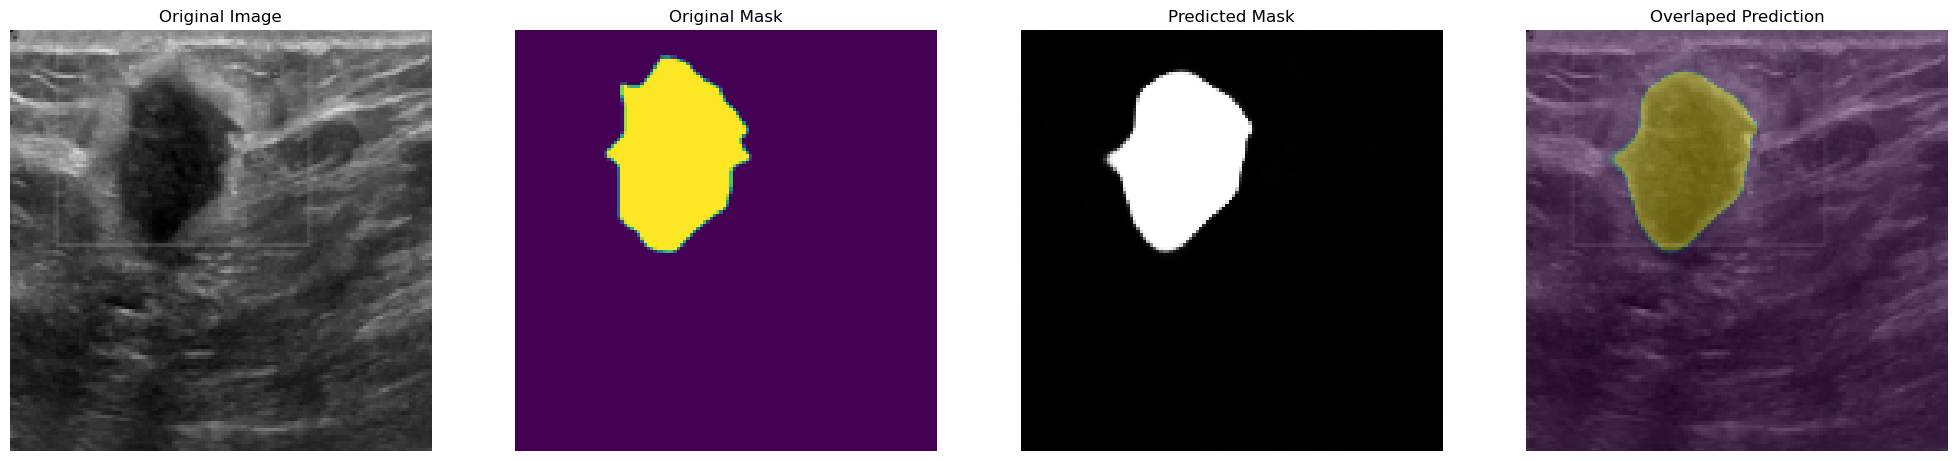

1/1 [==============================] - 0s 24ms/step


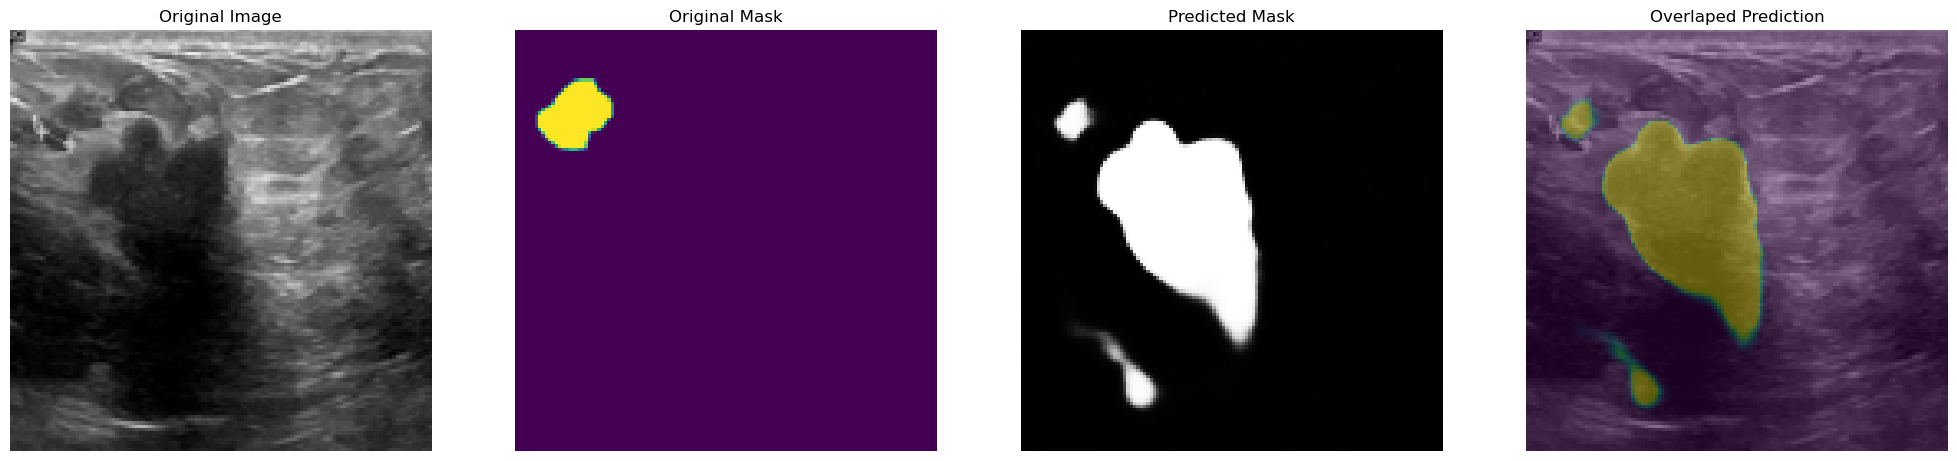


Epoch 15: val_loss improved from 0.31304 to 0.24873, saving model to training_inzynierka\checkpoint


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


INFO:tensorflow:Assets written to: training_inzynierka\checkpoint\assets


82/82 [==============================] - 33s 402ms/step - loss: 0.2331 - iou_score: 0.6734 - val_loss: 0.2487 - val_iou_score: 0.6525 - lr: 3.1623e-05
Epoch 16/500
82/82 [==============================] - ETA: 0s - loss: 0.2003 - iou_score: 0.7145
Epoch 16: val_loss did not improve from 0.24873
82/82 [==============================] - 18s 221ms/step - loss: 0.2003 - iou_score: 0.7145 - val_loss: 0.3004 - val_iou_score: 0.5778 - lr: 3.1623e-05
Epoch 17/500
82/82 [==============================] - ETA: 0s - loss: 0.1952 - iou_score: 0.7200
Epoch 17: val_loss did not improve from 0.24873
82/82 [==============================] - 18s 221ms/step - loss: 0.1952 - iou_score: 0.7200 - val_loss: 0.2862 - val_iou_score: 0.5963 - lr: 3.1623e-05
Epoch 18/500
82/82 [==============================] - ETA: 0s - loss: 0.1832 - iou_score: 0.7364
Epoch 18: val_loss did not improve from 0.24873
82/82 [==============================] - 18s 221ms/step - loss: 0.1832 - iou_score: 0.7364 - val_loss: 0.2881 - 

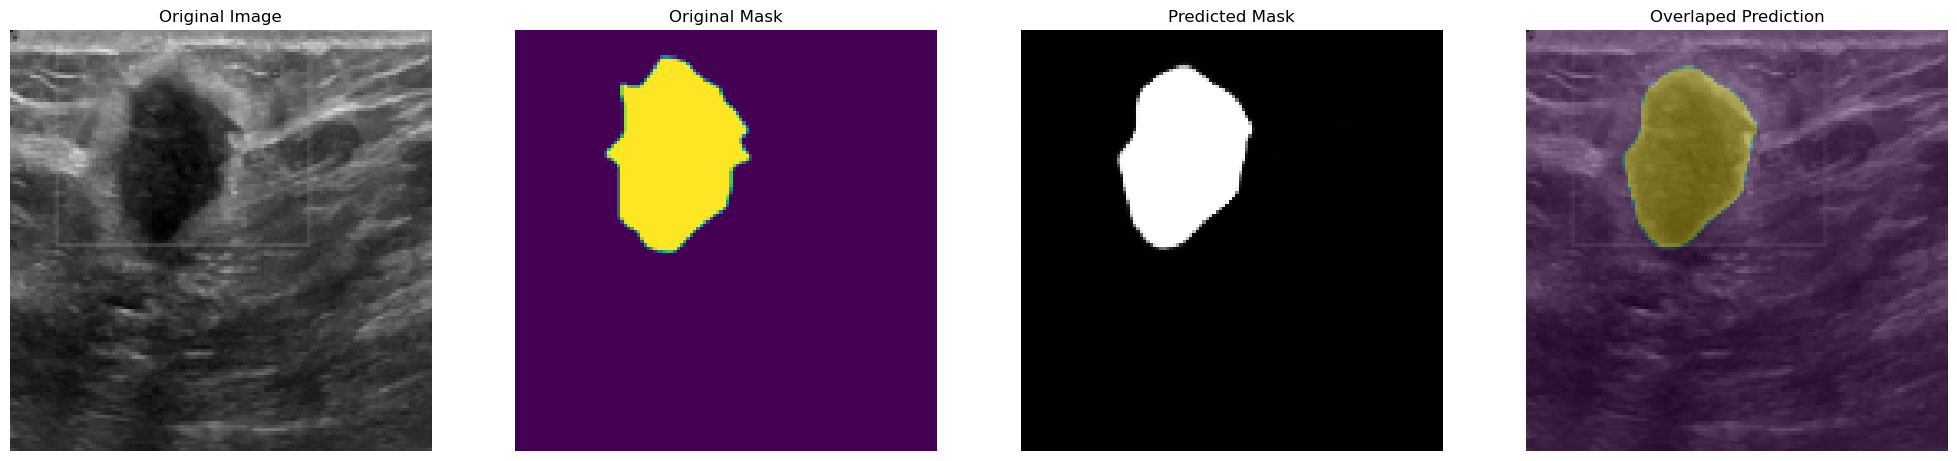

1/1 [==============================] - 0s 23ms/step


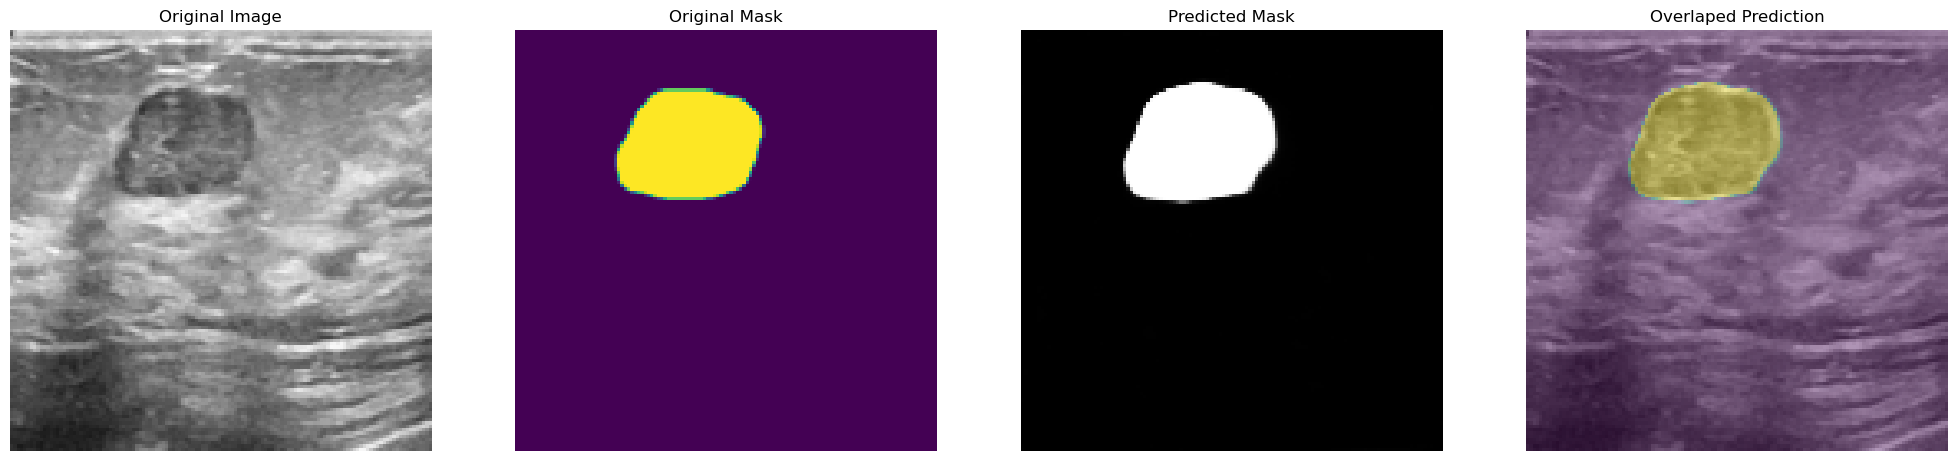


Epoch 20: val_loss did not improve from 0.24873
82/82 [==============================] - 19s 228ms/step - loss: 0.1662 - iou_score: 0.7578 - val_loss: 0.2628 - val_iou_score: 0.6153 - lr: 3.1623e-05
Epoch 21/500
82/82 [==============================] - ETA: 0s - loss: 0.1774 - iou_score: 0.7417
Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.

Epoch 21: val_loss did not improve from 0.24873
82/82 [==============================] - 18s 221ms/step - loss: 0.1774 - iou_score: 0.7417 - val_loss: 0.2499 - val_iou_score: 0.6404 - lr: 3.1623e-05
Epoch 22/500
82/82 [==============================] - ETA: 0s - loss: 0.1690 - iou_score: 0.7536
Epoch 22: val_loss did not improve from 0.24873
82/82 [==============================] - 18s 221ms/step - loss: 0.1690 - iou_score: 0.7536 - val_loss: 0.2756 - val_iou_score: 0.6098 - lr: 1.0000e-05
Epoch 23/500
82/82 [==============================] - ETA: 0s - loss: 0.1568 - iou_score: 0.7699
Epoch 23: val_loss did not improv

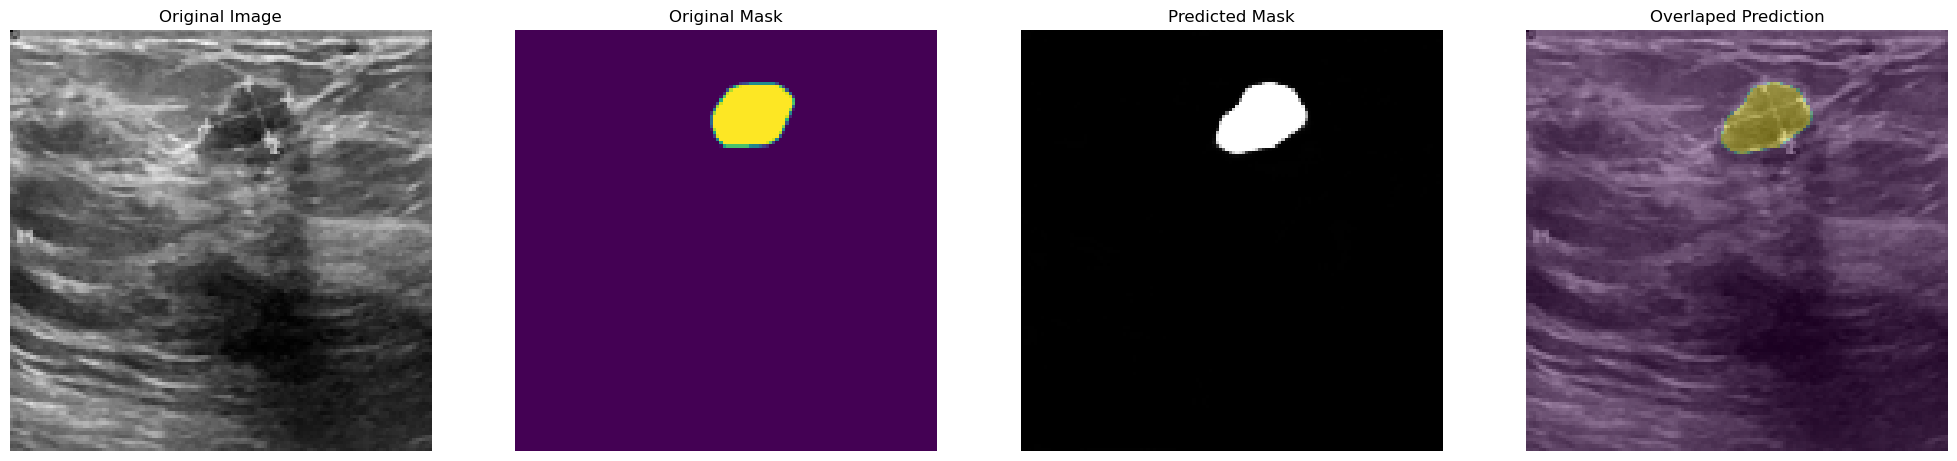

1/1 [==============================] - 0s 22ms/step


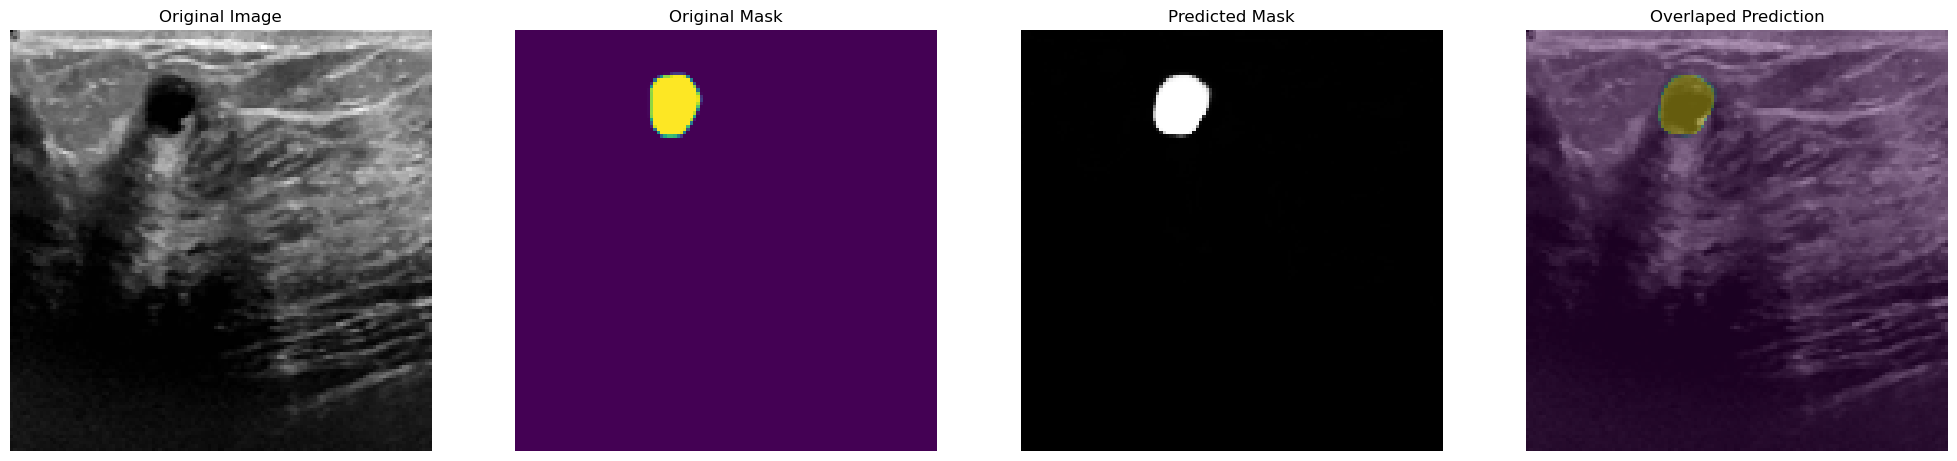


Epoch 25: val_loss did not improve from 0.24873
82/82 [==============================] - 19s 228ms/step - loss: 0.1549 - iou_score: 0.7728 - val_loss: 0.2780 - val_iou_score: 0.6038 - lr: 1.0000e-05
Epoch 26/500
82/82 [==============================] - ETA: 0s - loss: 0.1572 - iou_score: 0.7701
Epoch 26: val_loss did not improve from 0.24873
82/82 [==============================] - 18s 221ms/step - loss: 0.1572 - iou_score: 0.7701 - val_loss: 0.3322 - val_iou_score: 0.5510 - lr: 1.0000e-05
Epoch 27/500
82/82 [==============================] - ETA: 0s - loss: 0.1457 - iou_score: 0.7828
Epoch 27: ReduceLROnPlateau reducing learning rate to 3.162277292675049e-06.

Epoch 27: val_loss did not improve from 0.24873
82/82 [==============================] - 18s 222ms/step - loss: 0.1457 - iou_score: 0.7828 - val_loss: 0.3019 - val_iou_score: 0.5891 - lr: 1.0000e-05


In [22]:
history = model.fit(train_data,
                    verbose=1,
                    epochs=500,
                    validation_data=test_data,
                    shuffle=False, 
                    callbacks= callbacks)